In [3]:
import torch
from experiments.ModelLoader import load_encoder_decoder
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
checkpoint_path: str = "./experiments/checkpoints/vae_checkpoint_epoch_10.pt"
encoder, decoder = load_encoder_decoder(checkpoint_path, latent_dim=256)

In [7]:
latent_dim = 256
decoder.eval()


torch.Size([3, 64, 64])


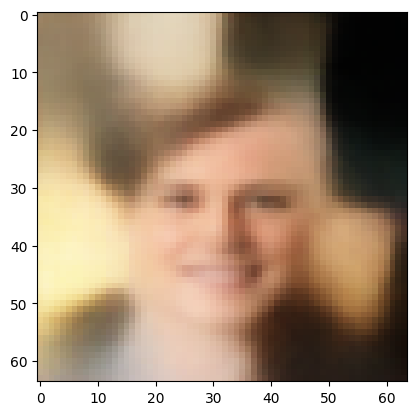

In [30]:
decoder.eval()
z = torch.randn([1, latent_dim, 2, 2]).to(device)
with torch.no_grad():
    img_arr = decoder(z).detach().cpu().squeeze(0).permute(1, 2, 0)
    # img_arr = 1 - img_arr
    print(decoder(z).detach().cpu().squeeze(0).shape)
    plt.imshow(img_arr)

In [31]:
from modules.SaveOutputs import save_samples_decoder

save_samples_decoder(decoder = decoder, out_dir = "G:\Python\VAE-latent-space-experiment\outputs", latent_dim = latent_dim, device = device)

TypeError: Invalid shape (3, 64, 64) for image data

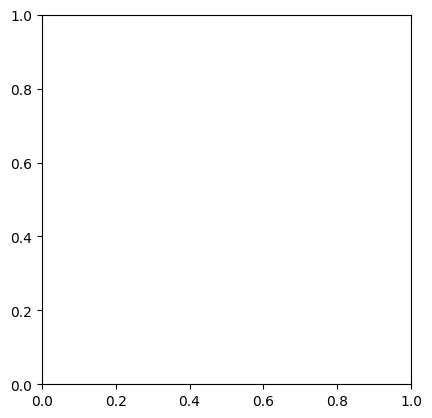

In [12]:
decoder.eval()
with torch.no_grad():
    decoder_inputs = torch.ones([1, latent_dim, 2, 2]).to(device)
    logits = decoder(decoder_inputs)
    x_gen = torch.sigmoid(logits).view(-1, 3, 64, 64).view(-1, 3, 64, 64).detach().squeeze().cpu().numpy()
plt.imshow(x_gen)
plt.axis('off')
plt.show()

In [112]:
latent_dim = 256
sliders = []

for i in range(latent_dim):
    slider = widgets.FloatSlider(
        value=0.0,
        min=-3.0,
        max=3.0,
        step=0.1,
        description=f'z{i}:',
        continuous_update=True,
        orientation='horizontal',
        layout=widgets.Layout(width='400px')
    )
    sliders.append(slider)

def update(change):
    with out:
        clear_output(wait=True)
        # Example: modify image based on slider values
        # modified_img = img * (slider1.value/100) + (slider2.value/100) - (slider3.value/100)
        # model.eval()
        decoder_inputs = torch.tensor([slider.value for slider in sliders]).to(device)
        decoder_input = np.array([slider.value for slider in sliders])
        decoder_input.reshape(4,5)
        print(decoder_inputs)
        decoder.eval()
        with torch.no_grad():
            logits = decoder(decoder_inputs)
            x_gen = torch.sigmoid(logits).view(-1, 1, 28, 28).view(-1, 1, 28, 28).detach().squeeze().cpu().numpy()
        plt.imshow(x_gen, cmap='gray')
        plt.axis('off')
        plt.show()

for slider in sliders:
    slider.observe(update, names='value')

In [113]:
out = widgets.Output()
ui = widgets.HBox([widgets.VBox(sliders), out])

display(ui)